In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from argparse import Namespace
from pathlib import Path
import torch
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule
from turboflow.evaluation import compute_all_metrics, angular_error_2Dfield, recostruction_error

from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp
from turboflow.utils import torch_utils as tch
from turboflow.utils import file_utils as fle
from turboflow.utils import viz_utils as viz

from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition, mark_inset

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import yaml

import seaborn as sns

from natsort import natsorted

/tmp/ipykernel_130339/834814389.py:17: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition, mark_inset


In [3]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=100000,
                         time_idx=862,
                         train_downsampling=8,
                         val_downsampling=4,
                         test_downsampling=1,
                         num_workers=1)
dm.setup()


X_lr, y_lr = dm.train_dataset[:]
img_shape_lr = dm.train_dataset.img_shape[:2]
shape_lr = dm.train_dataset.img_shape
L = shape_lr[0]
N_lr = X_lr.shape[0]
print(N_lr, L)

X_mr, y_mr = dm.val_dataset[:]
img_shape_mr = dm.val_dataset.img_shape[:2]
shape_mr = dm.val_dataset.img_shape
M = shape_mr[0]
N_mr = X_mr.shape[0]
print(N_mr, M)

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape
H = shape_hr[0]
N_hr = X_hr.shape[0]
print(N_hr, H)

dsets_dict = {}

dsets = {
    'train' : dm.train_dataset,
    'val' : dm.val_dataset,
    'test' : dm.test_dataset
}

for stage in dsets.keys():
    tmp = {}
    
    dset = dsets[stage]
    X, y = dset[:]
    img_shape = dset.img_shape[:2]
    shape = dset.img_shape
    R = shape[0]
    
    print(stage, X.shape, y.shape, R)
    
    tmp['X'] = X
    tmp['y'] = y
    tmp['R'] = R
    tmp['img_shape'] = img_shape
    
    dsets_dict[stage] = tmp

1024 32
4096 64
65536 256
train torch.Size([1024, 2]) torch.Size([1024, 2]) 32
val torch.Size([4096, 2]) torch.Size([4096, 2]) 64
test torch.Size([65536, 2]) torch.Size([65536, 2]) 256


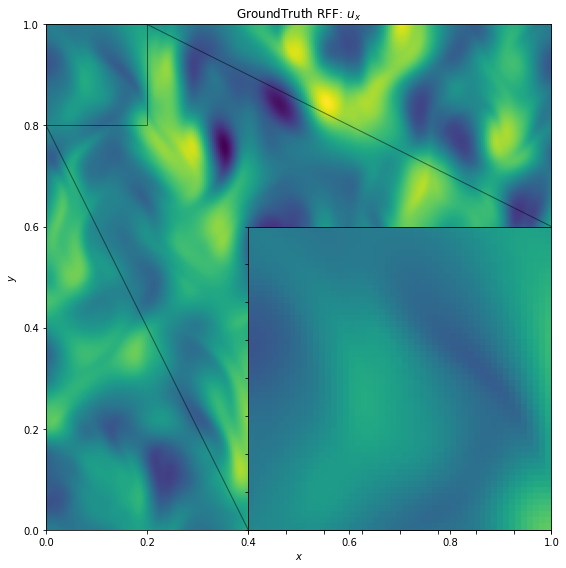

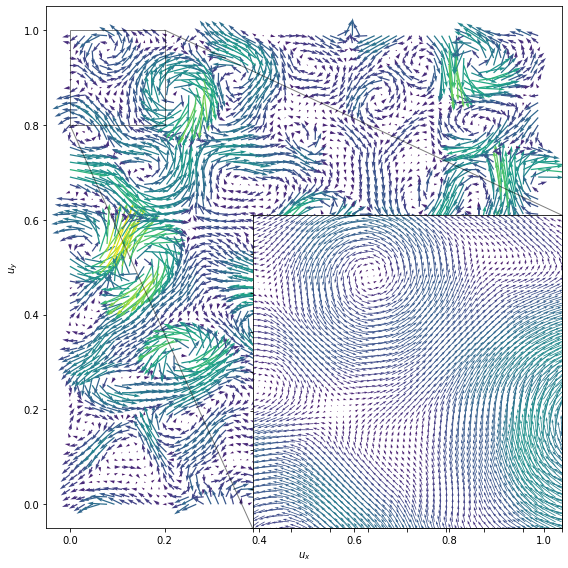

In [4]:
figsize = (8,8)
region=(0.00, 0.20, 0.80, 1)

Xlr = dsets_dict['train']['X']
Ulr = dsets_dict['train']['y']
L = dsets_dict['train']['R']
Xhr = dsets_dict['test']['X']
Uhr = dsets_dict['test']['y']
H = dsets_dict['test']['R']


viz.plot_lr_hr_inset(Uhr, Uhr, H, H, figsize=figsize, title='GroundTruth RFF', 
                     region = region,
                     only_u=True)
plt.show()

viz.plot_velocity_field(Xhr, Uhr, H, Xhr, Uhr, H,
                        title=None,
                        figsize=figsize,
                        region = region,
                        scale_lr=10, step_lr=4,
                        scale_hr=6, step_hr=1)
plt.tight_layout()
plt.show()

In [5]:
results_dir = Path('.','lxlaser2022')
files = glob.glob(str(results_dir.resolve()) + '/*.pkl')
files.sort(key=os.path.getmtime)
for f, file in enumerate(files):
    print(f, file.split('/')[-1])
# results_paths = natsorted(list(glob('*')))
results_paths = files

0 Turb2D_version_0.pkl
1 Turb2D_version_1.pkl
2 Turb2D_version_2.pkl
3 Turb2D_version_3.pkl
4 Turb2D_version_4.pkl
5 Turb2D_version_5.pkl
6 Turb2D_version_6.pkl
7 Turb2D_version_7.pkl
8 Turb2D_version_8.pkl
9 Turb2D_version_9.pkl
10 Turb2D_version_10.pkl
11 Turb2D_version_14.pkl
12 Turb2D_version_15.pkl
13 Turb2D_version_16.pkl
14 Turb2D_version_17.pkl
15 Turb2D_version_18.pkl
16 Turb2D_version_19.pkl
17 Turb2D_version_20.pkl


In [6]:
df = pd.DataFrame()

for p, path in enumerate(results_paths):
    path = Path(path)
    results_dict = fle.load_obj(path)
    
    df.at[p, 'name'] = results_dict['hparams']['name']
    df.at[p, 'version'] = results_dict['pl_version']
    
    for field in ['mlp_layers_num','rff_num','lam_sdiv', 'do_divfree', 'lam_curl','lam_grads', 'lam_sfn', 'lam_weight']:
        df.at[p, field] = results_dict['hparams'][field]
    
    df.at[p, 'rec'] = results_dict['metrics'][0]['test/metrics/reconstruction']
    df.at[p, 'ang'] = results_dict['metrics'][0]['test/metrics/angular_degree']
    
    df.at[p, 'model_path'] = results_dict['path']
    
df.to_csv(results_dir / Path('../results.csv'))
df

,name,version,mlp_layers_num,rff_num,lam_sdiv,do_divfree,lam_curl,lam_grads,lam_sfn,lam_weight,rec,ang,model_path
0,RFFNet,version_0,6.0,512.0,0.00000,False,0.0,0.0,0.000,0.000,0.018756,4.804039,/home/dicarlo_d/Documents/Code/TurboSuperResul...
1,RFFNet,version_1,6.0,512.0,0.00000,False,0.0,0.0,0.001,0.000,0.007192,3.128278,/home/dicarlo_d/Documents/Code/TurboSuperResul...
2,RFFNet,version_2,6.0,512.0,0.00000,False,0.0,0.0,0.100,0.000,0.006008,2.799828,/home/dicarlo_d/Documents/Code/TurboSuperResul...
3,RFFNet,version_3,6.0,512.0,0.00001,False,0.0,0.0,0.000,0.000,0.002905,1.982612,/home/dicarlo_d/Documents/Code/TurboSuperResul...
4,RFFNet,version_4,6.0,512.0,0.00001,False,0.0,0.0,0.001,0.000,0.002401,1.907458,/home/dicarlo_d/Documents/Code/TurboSuperResul...
5,RFFNet,version_5,6.0,512.0,0.00001,False,0.0,0.0,0.100,0.000,0.002871,2.055275,/home/dicarlo_d/Documents/Code/TurboSuperResul...
6,RFFNet,version_6,6.0,512.0,0.00100,False,0.0,0.0,0.000,0.000,0.001828,1.564434,/home/dicarlo_d/Documents/Code/TurboSuperResul...
7,RFFNet,version_7,6.0,512.0,0.00100,False,0.0,0.0,0.001,0.000,0.001284,1.420235,/home/dicarlo_d/Documents/Code/TurboSuperResul...
8,RFFNet,version_8,6.0,512.0,0.00100,False,0.0,0.0,0.100,0.000,0.002141,1.904724,/home/dicarlo_d/Documents/Code/TurboSuperResul...
9,RFFNet,version_9,6.0,512.0,0.00100,False,0.0,0.0,0.100,0.000,0.002486,2.086018,/home/dicarlo_d/Documents/Code/TurboSuperResul...


version_0 -- DF: False, Ldiv: 0.0, Lsfn: 0.0
-- LR 0.0189 (4.8718)
-- MR 0.0180 (4.7765)
-- HR 0.0181 (4.7880)
-- DF 0.0240


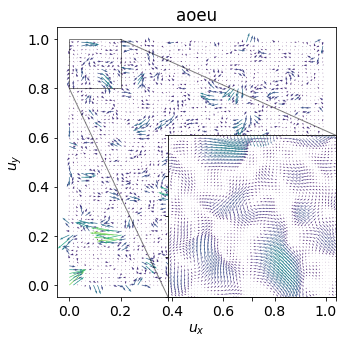

version_1 -- DF: False, Ldiv: 0.0, Lsfn: 0.001
-- LR 0.0079 (3.3073)
-- MR 0.0076 (3.2081)
-- HR 0.0076 (3.2155)
-- DF 0.0125


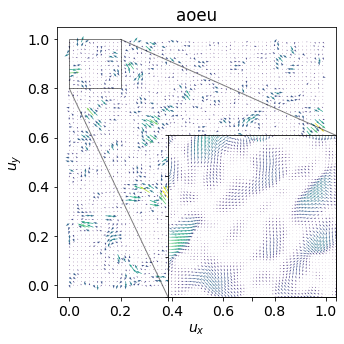

version_2 -- DF: False, Ldiv: 0.0, Lsfn: 0.1
-- LR 0.0064 (2.9313)
-- MR 0.0063 (2.8977)
-- HR 0.0063 (2.8991)
-- DF 0.0038


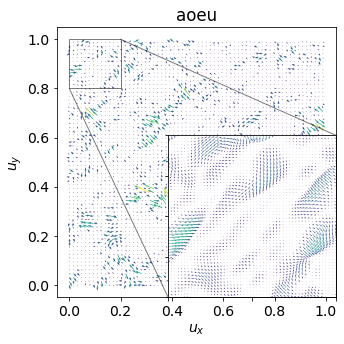

version_3 -- DF: False, Ldiv: 1e-05, Lsfn: 0.0
-- LR 0.0029 (1.9976)
-- MR 0.0028 (1.9596)
-- HR 0.0029 (1.9650)
-- DF 0.0094


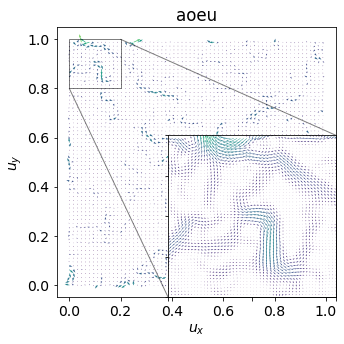

version_4 -- DF: False, Ldiv: 1e-05, Lsfn: 0.001
-- LR 0.0026 (2.0116)
-- MR 0.0024 (1.9362)
-- HR 0.0024 (1.9404)
-- DF 0.0042


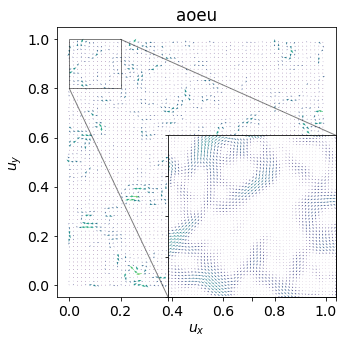

version_5 -- DF: False, Ldiv: 1e-05, Lsfn: 0.1
-- LR 0.0030 (2.1552)
-- MR 0.0029 (2.1047)
-- HR 0.0029 (2.1122)
-- DF 0.0050


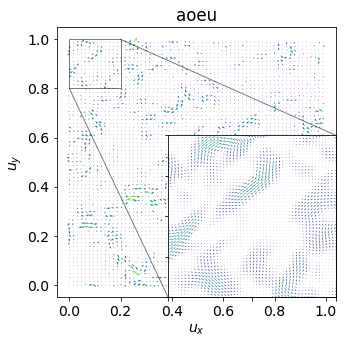

version_6 -- DF: False, Ldiv: 0.001, Lsfn: 0.0
-- LR 0.0018 (1.5697)
-- MR 0.0018 (1.5367)
-- HR 0.0018 (1.5472)
-- DF -0.0006


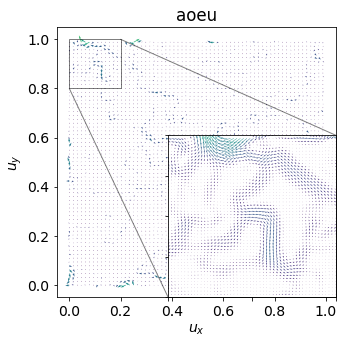

version_7 -- DF: False, Ldiv: 0.001, Lsfn: 0.001
-- LR 0.0014 (1.5091)
-- MR 0.0013 (1.4420)
-- HR 0.0013 (1.4478)
-- DF 0.0000


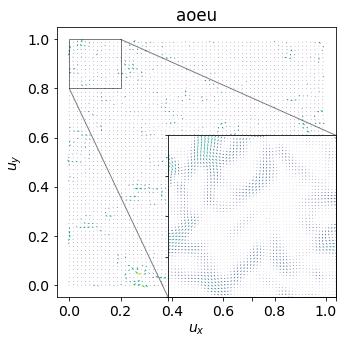

version_8 -- DF: False, Ldiv: 0.001, Lsfn: 0.1
-- LR 0.0024 (2.0210)
-- MR 0.0022 (1.9599)
-- HR 0.0023 (1.9669)
-- DF 0.0017


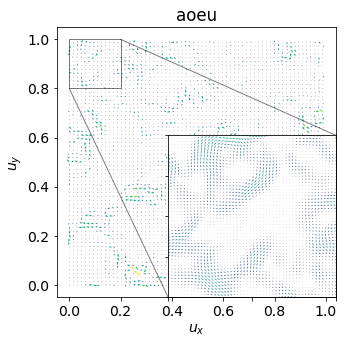

version_9 -- DF: False, Ldiv: 0.001, Lsfn: 0.1
-- LR 0.0029 (2.2889)
-- MR 0.0028 (2.2317)
-- HR 0.0028 (2.2386)
-- DF 0.0011


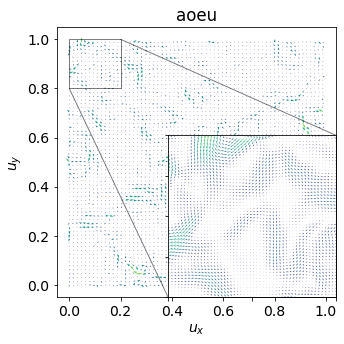

version_10 -- DF: True, Ldiv: 0.0, Lsfn: 0.0
-- LR 0.0320 (7.6288)
-- MR 0.0309 (7.4993)
-- HR 0.0310 (7.5077)
-- DF 0.0000


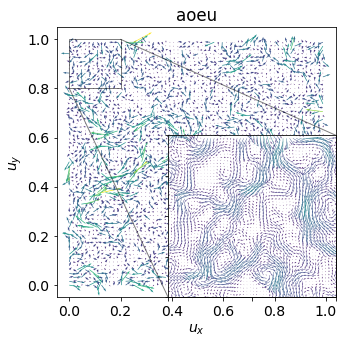

version_14 -- DF: True, Ldiv: 0.0, Lsfn: 0.001
-- LR 0.0303 (7.1937)
-- MR 0.0292 (7.0742)
-- HR 0.0291 (7.0541)
-- DF 0.0000


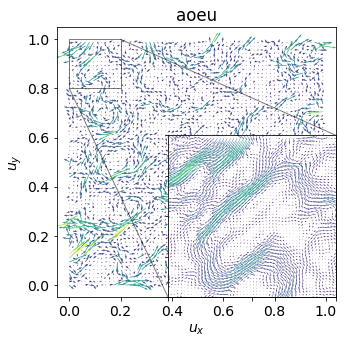

version_15 -- DF: True, Ldiv: 0.0, Lsfn: 0.1
-- LR 0.0337 (7.6569)
-- MR 0.0340 (7.6406)
-- HR 0.0340 (7.6627)
-- DF 0.0000


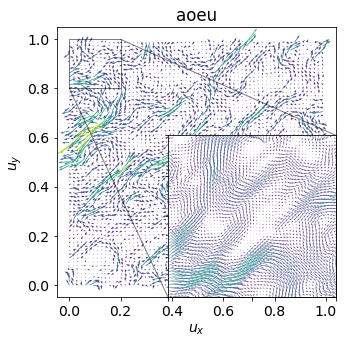

version_16 -- DF: True, Ldiv: 0.0, Lsfn: 0.01
-- LR 0.0411 (8.9489)
-- MR 0.0419 (8.9575)
-- HR 0.0419 (8.9440)
-- DF -0.0000


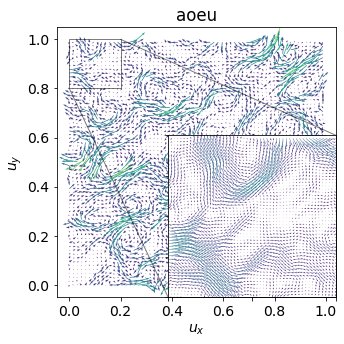

version_17 -- DF: True, Ldiv: 0.0, Lsfn: 0.0
-- LR 0.0873 (12.4300)
-- MR 0.0833 (11.9395)
-- HR 0.0841 (11.9693)
-- DF -0.0001


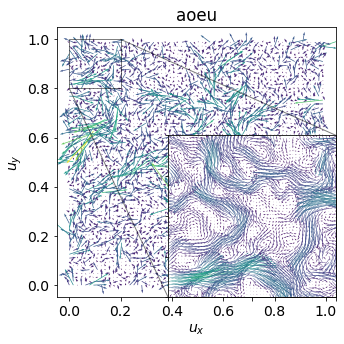

version_18 -- DF: True, Ldiv: 0.0, Lsfn: 0.001
-- LR 0.0326 (7.1573)
-- MR 0.0328 (7.1491)
-- HR 0.0327 (7.1461)
-- DF 0.0000


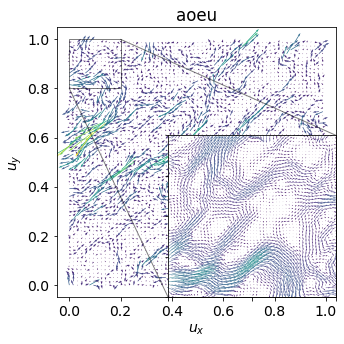

version_19 -- DF: True, Ldiv: 0.0, Lsfn: 0.1
-- LR 0.0316 (7.2289)
-- MR 0.0316 (7.2054)
-- HR 0.0316 (7.2188)
-- DF 0.0000


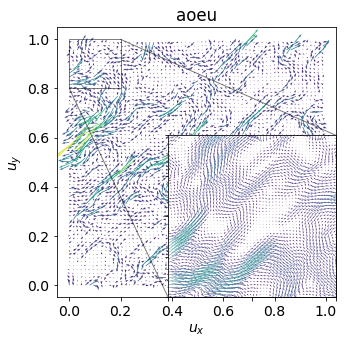

version_20 -- DF: True, Ldiv: 0.0, Lsfn: 0.0
-- LR 0.0738 (11.6019)
-- MR 0.0731 (11.4362)
-- HR 0.0736 (11.4801)
-- DF 0.0000


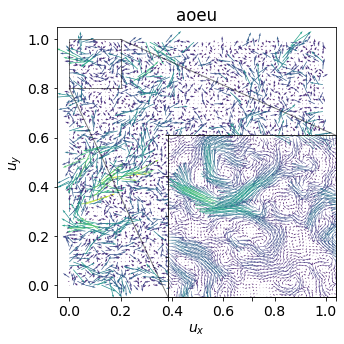

In [19]:
Xlr = dsets_dict['train']['X']
Ulr = dsets_dict['train']['y']
L = dsets_dict['train']['R']
Xmr = dsets_dict['val']['X']
Umr = dsets_dict['val']['y']
M = dsets_dict['val']['R']
Xhr = dsets_dict['test']['X']
Uhr = dsets_dict['test']['y']
H = dsets_dict['test']['R']

curr_df = df

figsize = (8,8)

res_df = pd.DataFrame()

c = 0
for r, row in curr_df.iterrows():    
    
    model_path = row['model_path']
    do_divfree = row['do_divfree']
    lam_sdiv = row['lam_sdiv']
    lam_sfun = row['lam_sfn']
    version = row['version']
    
    print(f'{version} -- DF: {do_divfree}, Ldiv: {lam_sdiv}, Lsfn: {lam_sfun}')
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    model = plDivFreeRFFNet.load_from_checkpoint(model_path)
    model.eval()
    
    
    res_df.at[c, 'version'] = version
    res_df.at[c, 'do_divfree'] = do_divfree
    res_df.at[c, 'lam_sdiv'] = lam_sdiv
    res_df.at[c, 'lam_sfun'] = lam_sfun
    
    Ulr_pred = model(X_lr)[0]
    Umr_pred = model(X_mr)[0]
    Uhr_pred = model(X_hr)[0]
    
    err_lr = recostruction_error(Ulr_pred, Ulr, avg=False)
    err_mr = recostruction_error(Umr_pred, Umr, avg=False)
    err_hr = recostruction_error(Uhr_pred, Uhr, avg=False)

    ang_lr = angular_error_2Dfield(Ulr_pred, Ulr, avg=False)
    ang_mr = angular_error_2Dfield(Umr_pred, Umr, avg=False)
    ang_hr = angular_error_2Dfield(Uhr_pred, Uhr, avg=False)
    
    
    res_df.at[c, 'err_lr'] = err_lr.mean().item()
    res_df.at[c, 'err_mr'] = err_mr.mean().item()
    res_df.at[c, 'err_hr'] = err_hr.mean().item()
    
    res_df.at[c, 'ang_lr'] = ang_lr.mean().item()
    res_df.at[c, 'ang_mr'] = ang_mr.mean().item()
    res_df.at[c, 'ang_hr'] = ang_hr.mean().item()
    
    xy = Xhr.view(H,H,2).detach().cpu()
    uv = Uhr_pred.view(H,H,2).detach().cpu()
    div = phy.compute_divergence((xy[:,:,0], xy[:,:,1]), (uv[:,:,0], uv[:,:,1]))[2:-2,2:-2]
        
    res_df.at[c, 'div_viol'] = np.abs(div).mean()
    
#     print('-- LR %1.4f +- %1.4f (%1.4f +- %1.4f)' % (err_lr.mean(), err_lr.std(), ang_lr.mean(), ang_lr.std()))
#     print('-- MR %1.4f +- %1.4f (%1.4f +- %1.4f)' % (err_mr.mean(), err_mr.std(), ang_mr.mean(), ang_mr.std()))
#     print('-- HR %1.4f +- %1.4f (%1.4f +- %1.4f)' % (err_hr.mean(), err_hr.std(), ang_hr.mean(), ang_hr.std()))
#     print('-- DF %1.4f +- %1.4f' % (div.mean(), div.std()))
    
    print('-- LR %1.4f (%1.4f)' % (err_lr.mean(), ang_lr.mean()))
    print('-- MR %1.4f (%1.4f)' % (err_mr.mean(), ang_mr.mean()))
    print('-- HR %1.4f (%1.4f)' % (err_hr.mean(), ang_hr.mean()))
    print('-- DF %1.4f' % (div.mean()))
    
    title = 'aoeu'

    figsize = (5,5)   
    Err_hr = (Uhr_pred - Uhr).detach().cpu()
    viz.plot_velocity_field(Xhr.detach().cpu(), Err_hr, H, 
                        Xhr.detach().cpu(), Err_hr, H,
                        title=title,
                        figsize=figsize,
                        region = region,
                        scale_lr=10, step_lr=4,
                        scale_hr=5, step_hr=1)
    plt.tight_layout()
    plt.show()
    
    c += 1
    # plots
#     hc_or_sc = 'Hard' if do_divfree else 'Soft'
#     title = r'%s $\lambda$ = %.1E $\lambda$ = %.1E' % (hc_or_sc, lam_grads, lam_curl)
#     title = ''
#     print(version, title)
    
#     from turboflow.models.phyrff_hard import plDivFreeRFFNet
#     model = plDivFreeRFFNet.load_from_checkpoint(model_path)
    
#     Uhr = model(X_hr)[0]
#     Uhr = Uhr.detach().cpu().numpy()

#     from turboflow.models.phyrff_hard import plDivFreeRFFNet
#     model = plDivFreeRFFNet.load_from_checkpoint(model_path)

#     viz.plot_lr_hr_inset(Uhr, Uhr, H, H, figsize=figsize, title=title, 
#                          region = region,
#                          only_u=True)
#     plt.show()

#     viz.plot_velocity_field(Xhr.detach().cpu(), Uhr, L, Xhr.detach().cpu(), Uhr, H,
#                             title=title,
#                             figsize=figsize,
#                             region = region,
#                             scale_lr=10, step_lr=4,
#                             scale_hr=5, step_hr=1)
#     plt.tight_layout()
#     plt.show()

In [20]:
res_df

,version,do_divfree,lam_sdiv,lam_sfun,err_lr,err_mr,err_hr,ang_lr,ang_mr,ang_hr,div_viol
0,version_0,False,0.00000,0.000,0.018948,0.018008,0.018077,4.871759,4.776468,4.787996,5.354463
1,version_1,False,0.00000,0.001,0.007942,0.007556,0.007565,3.307290,3.208107,3.215545,4.006780
2,version_2,False,0.00000,0.100,0.006386,0.006312,0.006328,2.931317,2.897671,2.899127,4.435267
3,version_3,False,0.00001,0.000,0.002881,0.002806,0.002873,1.997622,1.959585,1.964971,0.292246
4,version_4,False,0.00001,0.001,0.002569,0.002420,0.002434,2.011552,1.936166,1.940437,0.582741
5,version_5,False,0.00001,0.100,0.003042,0.002917,0.002940,2.155169,2.104704,2.112247,1.188815
6,version_6,False,0.00100,0.000,0.001818,0.001773,0.001841,1.569739,1.536687,1.547220,0.077896
7,version_7,False,0.00100,0.001,0.001439,0.001311,0.001320,1.509112,1.441956,1.447755,0.076731
8,version_8,False,0.00100,0.100,0.002379,0.002239,0.002256,2.021036,1.959933,1.966921,0.112559
9,version_9,False,0.00100,0.100,0.002922,0.002794,0.002821,2.288907,2.231655,2.238618,0.214086


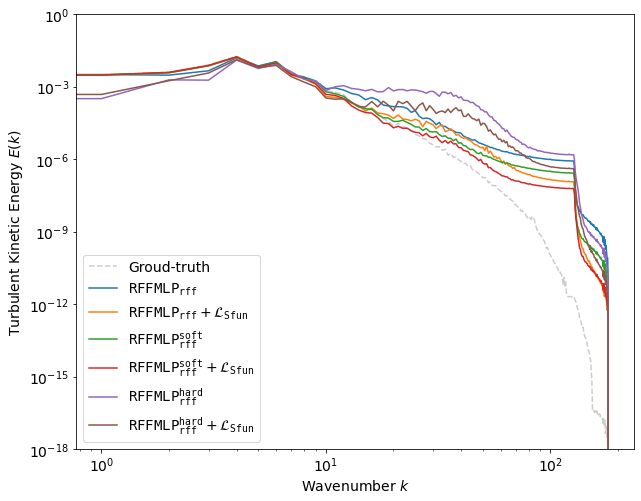

In [40]:
Xlr = dsets_dict['train']['X']
Ulr = dsets_dict['train']['y']
L = dsets_dict['train']['R']
Xhr = dsets_dict['test']['X']
Uhr = dsets_dict['test']['y']
H = dsets_dict['test']['R']

plt.rcParams["font.size"] = "14"
fig, ax1 = plt.subplots(figsize=(10,8))

speclr_gt = phy.energy_spectrum(Ulr.view(L,L,2).permute(2,0,1))[0]
spechr_gt = phy.energy_spectrum(Uhr.view(H,H,2).permute(2,0,1))[0]

# ax1.loglog(speclr_gt.detach(), 'k--', alpha=0.2, )
ax1.loglog(spechr_gt.detach(), 'k--', alpha=0.2, label = 'Groud-truth')

figsize = (8,)

c = 0
for r, row in curr_df.iterrows():    
    
    model_path = row['model_path']
    do_divfree = row['do_divfree']
    lam_sdiv = row['lam_sdiv']
    lam_sfun = row['lam_sfn']
    version = row['version']
    
    if r not in [0, 2, 6, 7, 14, 16]:
        continue
        
    if r == 0:
        label = r'$\mathtt{RFFMLP}_\mathtt{rff}$'
    if r == 2:
        label = r'$\mathtt{RFFMLP}_\mathtt{rff} + \mathcal{L}_\mathtt{Sfun}$'
    if r == 6:
        label = r'$\mathtt{RFFMLP}_\mathtt{rff}^\mathtt{soft}$'
    if r == 7:        
        label = r'$\mathtt{RFFMLP}_\mathtt{rff}^\mathtt{soft} + \mathcal{L}_\mathtt{Sfun}$'
    if r == 14:
        label = r'$\mathtt{RFFMLP}_\mathtt{rff}^\mathtt{hard}$'
    if r == 16:        
        label = r'$\mathtt{RFFMLP}_\mathtt{rff}^\mathtt{hard} + \mathcal{L}_\mathtt{Sfun}$'
    
#     label = f'DF: {do_divfree}, Ldiv: {lam_sdiv}, Lsfn: {lam_sfun}'
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    model = plDivFreeRFFNet.load_from_checkpoint(model_path)
    model.eval()
    
#     Ulr_pred = model(X_lr)[0]
#     Umr_pred = model(X_mr)[0]

    Uhr_pred = model(X_hr)[0]
    
#     spec = phy.energy_spectrum(Ulr_pred.view(L,L,2).permute(2,0,1))[0]
#     plt.loglog(spec.detach().cpu().numpy(), alpha=0.2, color=f'C{c}')
    
    yhr_hat = model(Xhr)[0]
    spec = phy.energy_spectrum(Uhr_pred.view(H,H,2).permute(2,0,1))[0]
    plt.loglog(spec.detach().cpu().numpy(), label=f'{label}', color=f'C{c}')

    c+=1

    
plt.ylim([1e-18, 1])
plt.legend(loc='lower left')
plt.ylabel(r'Turbulent Kinetic Energy $E(k)$')
plt.xlabel(r'Wavenumber $k$')
plt.show()